# Parameter Fitting with Normalizing Flows

Instead of training classifiers to learn likelihood ratios, another approach consists in directly learning the pdfs of the processes involved. Several generative models can be used to do this, in our case we choose normalizing flows.
After running [Neural_Likelihood_Ratio_Estimation.ipynb](https://github.com/iris-hep/NSBI-workflow-tutorial/blob/main/cms_ttbar_open_data/Neural_Likelihood_Ratio_Estimation.ipynb), proceed with 
```
python train_flow.py -p ttbar
python train_flow.py -p wjets
python train_flow.py -p single_top_t_chan
```
This will train one normalizing flow per process. 

After this, one can run
```
python evaluate_flows.py
```
to use the flows we just trained to compute the probabilites of the test events. These probabilities will then be used in this notebook to build the test statistic and perform hypothesis testing.

In [1]:
import os, sys, importlib
sys.path.append('../')

import nsbi_common_utils
from nsbi_common_utils import plotting, training
import glob
import numpy as np

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.optimizers import Nadam
import mplhep as hep
import pickle
import matplotlib.pyplot as plt
hep.style.use(hep.style.ATLAS)


/work/gallim/Postdoc/SBI/NSBI-workflow-tutorial/src/nsbi_common_utils/plotting.py:11: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style("ATLAS")
2025-08-11 18:14:02.321678: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
saved_data = './cached_data/'

dataset = pd.read_hdf(f"{saved_data}dataset_preselected_nominal_ttbar.h5", key="dataset", mode='r')

mask_ttbar = dataset.type=='ttbar'
mask_singletop = dataset.type=='single_top_t_chan'
mask_wjets = dataset.type=='wjets'

# Mask that extracts the expected Asimov dataset
# Trivially the full dataset for the ttbar dataset used here, but not generally true
mask_Asimov = mask_ttbar | mask_singletop | mask_wjets
weights_Asimov = jnp.array(dataset[mask_Asimov].weights.ravel())

/tmp/ipykernel_201417/1333378137.py:12: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  weights_Asimov = jnp.array(dataset[mask_Asimov].weights.ravel())


In [3]:
# Get the expected yields corresponding to the various channels

nu_ttbar = dataset[mask_ttbar].weights.sum()
print(f"expected ttbar yield = {nu_ttbar} events")

nu_singletop = dataset[mask_singletop].weights.sum()
print(f"expected single top yield = {nu_singletop}")

nu_wjets = dataset[mask_wjets].weights.sum()
print(f"expected wjets yield = {nu_wjets}")

expected ttbar yield = 249104.69705455826 events
expected single top yield = 164939.94600394968
expected wjets yield = 2841709.825644889


In [4]:
# with flows

import pickle
with open("flows/probs.pkl", "rb") as f:
    probs = pickle.load(f)
processes = ["ttbar", "wjets", "single_top_t_chan"]
for process in processes:
    probs[process] = probs[process][mask_Asimov]

In [5]:
probs["ttbar"]

array([2.6190479e-05, 1.2109430e-04, 7.6822915e-05, ..., 2.0703116e-04,
       1.0567802e-03, 1.2377113e-03], shape=(447789,), dtype=float32)

In [6]:
probs['wjets'].shape

(447789,)

In [7]:
# Load the Control Region summary histogram
with open(f"{saved_data}hist_CR_ttbar.pkl", "rb") as fp:
    hist_CR_ttbar = pickle.load(fp)

nu_CR_ttbar = jnp.array(hist_CR_ttbar['ttbar'])
nu_CR_singletop = jnp.array(hist_CR_ttbar['single_top_t_chan'])
nu_CR_wjets = jnp.array(hist_CR_ttbar['wjets'])

In [8]:
hist_CR_ttbar

{'ttbar': array([  1659.08446837,    509.91905709,    639.24635418,    966.25966254,
          1154.70800972,   1644.30420585, 391981.79981331, 184978.68055968,
        130962.3636311 ]),
 'single_top_t_chan': array([ 7888.66626006,  2291.29989043,  2983.73677362,  3667.42566897,
         4531.45769814,  5731.27787571, 36959.57567755, 29837.36773624,
        34148.77989409]),
 'single_top_tW': array([  614.18920344,   184.07540595,   223.0667481 ,   301.35169086,
          373.59146429,   509.00325718, 24636.48306773, 15379.51528012,
        15102.94878349]),
 'wjets': array([11982861.4125296 ,   997413.00831301,   945100.55146481,
          893332.57975595,   837795.09554401,   794487.58523093,
          899196.26587184,   906107.03879414,  1040846.16904286])}

Neglecting the $\alpha$-dependence, we can build the model:

$$p(x|\mu) = \frac{1}{\sum_c \cdot f_c(\mu) \cdot \nu_c} \sum_c f_c(\mu) \cdot \nu_c \cdot p_c(x)$$

In [9]:
# Build the model

# rate term - binned Control Region (Poisson fitting)
@jax.jit
def nu_CR(mu):

    nu = mu * nu_CR_ttbar + nu_CR_singletop + nu_CR_wjets

    return nu

# rate term - Signal Region (NSBI)
@jax.jit
def nu(mu):

    nu = mu * nu_ttbar + nu_singletop + nu_wjets

    return nu

# per event term
@jax.jit
def log_ratio_mu_flow(mu):

    dnu_mu = mu * nu_ttbar * probs["ttbar"] + nu_singletop * probs["single_top_t_chan"] + nu_wjets * probs["wjets"]

    return jnp.log( dnu_mu / nu(mu) )

And the test statistic function (again assuming no nuisance parameters) can be written as:

$$t_\mu = -2 \cdot \sum_\text{bin}^\text{CR}\frac{\text{Pois}(\mathcal{N}_\text{bin}|\nu_\text{bin}(\mu))}{\text{Pois}(\mathcal{N}_\text{bin}|\nu_\text{bin}(\hat{\mu}))} -2 \cdot \frac{\text{Pois}(\mathcal{N}_\text{evts}|\nu(\mu))}{\text{Pois}(\mathcal{N}_\text{evts}|\nu(\hat{\mu}))} -2 \cdot \sum_i^{\mathcal{N}_\text{evts}} w_i \times \log \frac{p(x_i|\mu)}{p(x_i|\hat{\mu})}$$

In [10]:
# The full NLL function
@jax.jit
def full_nll_function_flow(mu, mu_Asimov=1.0):
    mu = jnp.array(mu)
    mu_Asimov = jnp.array(mu_Asimov)

    pois_llr_CR = -2 * nu_CR(mu_Asimov) * jnp.log(nu_CR(mu)) + 2 * nu_CR(mu)
    
    pois_llr_SR = -2 * nu(mu_Asimov) * jnp.log(nu(mu)) + 2 * nu(mu)
    
    nsbi_llr_SR = -2 * jnp.sum(jnp.multiply(weights_Asimov, log_ratio_mu_flow(mu)))

    ret =  pois_llr_CR.sum() + pois_llr_SR + nsbi_llr_SR
    ret = ret[0]
    
    return ret

In [11]:
from iminuit import Minuit

param_vec = ['mu']
param_tuple = jnp.ones(len(param_vec))

m1_flow = Minuit(full_nll_function_flow, param_tuple, grad=None, name=tuple(param_vec))
m1_flow.errordef = Minuit.LEAST_SQUARES
strategy = 0
# strategy = 2
m1_flow.strategy = strategy
m1_flow.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -6.156e+08                 │              Nfcn = 22               │
│ EDM = 0.000829 (Goal: 0.0002)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │        Covariance APPROXIMATE        │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu   │  1.0388   │  0.0022   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬──────────┐
│    │       mu │
├────┼──────────┤
│ mu │ 4.71e-06 │
└────┴──────────┘

In [12]:
param_tuple

Array([1.], dtype=float64)

Text(1, 0, '$\\mu_{t\\bar{t}}$')

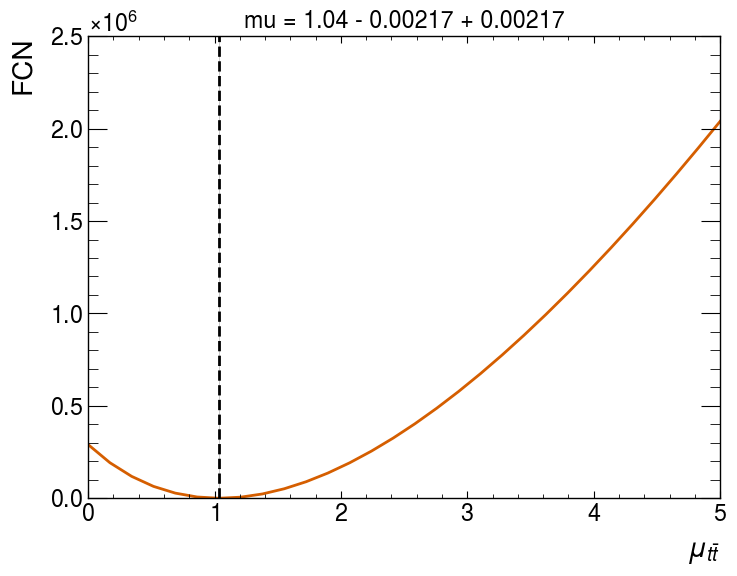

In [13]:
# Draw the profile likelihood scan for the POI mu
#m1.draw_mnprofile('mu', bound=(0.0, 5.0))
m1_flow.draw_mnprofile('mu', bound=(0.0, 5.0))
plt.axis(ymin=0.0)
plt.xlabel(r'$\mu_{t\bar{t}}$')

So the best-fit value from the toy analysis with Asimov dataset does not converge to the truth value - $\widehat{\mu}_{t\bar{t}} \neq \mu^\text{truth}_{t\bar{t}} = 1.0$.

Unlike a binned Poisson likelihood fit, which by definition converges to the truth value for Asimov and has well-defined asymptotic statistical properties - this is not guaranteed in an NSBI analysis.

**Adding nuisance parameters:**

Now as an example lets add unconstrained nuisance parameters to the fit - related to background modelling. Will be adding constrained nuisance parameters in a later version of the workflow.

In [14]:
# rate term - binned Control Region (Poisson fitting)
@jax.jit
def nu_CR(mu_vec):

    mu, mu_singletop, mu_wjets = mu_vec

    nu = mu * nu_CR_ttbar \
        + mu_singletop * nu_CR_singletop \
        + mu_wjets * nu_CR_wjets

    return nu
    
# rate term - Signal Region (NSBI)
def nu(mu_vec):
    
    mu, mu_singletop, mu_wjets = mu_vec
    nu = mu * nu_ttbar \
        + mu_singletop * nu_singletop \
        + mu_wjets * nu_wjets

    return nu
    
# per event term
def log_ratio_mu_flow(mu_vec):

    mu, mu_singletop, mu_wjets = mu_vec

    dnu_mu = mu * nu_ttbar * probs["ttbar"] + nu_singletop * probs["single_top_t_chan"] + nu_wjets * probs["wjets"]
    
    return jnp.log( dnu_mu / nu(mu_vec) )

# The full NLL function
def full_nll_function_flow(mu):

    mu_Asimov=[1.0, 1.0, 1.0]
    
    pois_llr_CR = -2 * nu_CR(mu_Asimov) * jnp.log(nu_CR(mu)) \
                + 2 * nu_CR(mu)
    pois_llr = -2 * nu(mu_Asimov) * jnp.log(nu(mu)) + 2 * nu(mu)
    nsbi_llr = -2 * jnp.sum(jnp.multiply(weights_Asimov, log_ratio_mu_flow(mu)))

    ret = pois_llr_CR.sum() + pois_llr + nsbi_llr
    
    return ret

In [15]:
from iminuit import Minuit

# param_vec = ['mu', 'mu_singletop']
param_vec = ['mu', 'mu_singletop', 'mu_wjets']

param_tuple = jnp.ones(len(param_vec))

m1 = Minuit(jax.jit(full_nll_function_flow), param_tuple, grad=None, name=tuple(param_vec))
m1.errordef = Minuit.LEAST_SQUARES

limits = []
for param_ in enumerate(param_vec):
    
    limits.append([1e-10,None])
        
limits = tuple(limits)
m1.limits = limits

strategy = 0
# strategy = 2
m1.strategy = strategy
m1.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -6.164e+08                 │              Nfcn = 65               │
│ EDM = 7.2e-05 (Goal: 0.0002)     │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │        Covariance APPROXIMATE        │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name         │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu           │  1.5013   │  0.0023   │            │            │  1e-10  │         │       │
│ 1 │ mu_singletop │     0     │  3.2e-6   │            │            │  1e-10  │         │       │
│ 2 │ mu_wjets     │ 860.15e-3 │  0.21e-3  │            │            │  1e-10  │         │       │
└───┴──────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────────┬────────────────────────────────────────┐
│              │           mu mu_singletop     mu_wjets │
├──────────────┼────────────────────────────────────────┤
│           mu │     5.22e-06   -38.83e-15     -0.12e-6 │
│ mu_singletop │   -38.83e-15     8.29e-17    -5.40e-15 │
│     mu_wjets │     -0.12e-6    -5.40e-15     4.29e-08 │
└──────────────┴────────────────────────────────────────┘

In [16]:
from iminuit import Minuit

param_vec = ['mu', 'mu_singletop']
param_vec = ['mu', 'mu_singletop', 'mu_wjets']

param_tuple = jnp.ones(len(param_vec))

m1_flow = Minuit(jax.jit(full_nll_function_flow), param_tuple, grad=jax.jit(jax.grad(full_nll_function_flow)), name=tuple(param_vec))
m1_flow.errordef = Minuit.LEAST_SQUARES

limits = []
for param_ in enumerate(param_vec):
    
    limits.append([1e-10,None])
        
limits = tuple(limits)
m1_flow.limits = limits

strategy = 0
# strategy = 2
m1_flow.strategy = strategy
m1_flow.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -6.164e+08                 │         Nfcn = 22, Ngrad = 5         │
│ EDM = 9.82e-05 (Goal: 0.0002)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │        Covariance APPROXIMATE        │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name         │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu           │  1.5013   │  0.0023   │            │            │  1e-10  │         │       │
│ 1 │ mu_singletop │     0     │  3.2e-6   │            │            │  1e-10  │         │       │
│ 2 │ mu_wjets     │ 860.15e-3 │  0.21e-3  │            │            │  1e-10  │         │       │
└───┴──────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────────┬────────────────────────────────────────┐
│              │           mu mu_singletop     mu_wjets │
├──────────────┼────────────────────────────────────────┤
│           mu │     5.06e-06   -38.72e-15     -0.12e-6 │
│ mu_singletop │   -38.72e-15     5.36e-17     0.43e-15 │
│     mu_wjets │     -0.12e-6     0.43e-15     4.32e-08 │
└──────────────┴────────────────────────────────────────┘

Profiled negative log-likelihood scans
===

Now adding unconstrained nuisance parameters associated with the background normalization:

$$t_\mu = -2 \cdot \sum_\text{bin}^\text{CR}\frac{\text{Pois}(\mathcal{N}_\text{bin}|\nu_\text{bin}(\mu, \hat{\hat{\mu}}_\text{bkg}))}{\text{Pois}(\mathcal{N}_\text{bin}|\nu_\text{bin}(\hat{\mu}, \hat{\mu}_\text{bkg}))} 
-2 \cdot \frac{\text{Pois}(\mathcal{N}_\text{evts}|\nu(\mu, \hat{\hat{\mu}}_\text{bkg}))}{\text{Pois}(\mathcal{N}_\text{evts}|\nu(\hat{\mu}, \hat{\mu}_\text{bkg}))} -2 \cdot \sum_i^{\mathcal{N}_\text{evts}} w_i \times \log \frac{p(x_i|\mu, \hat{\hat{\mu}}_\text{bkg})}{p(x_i|\hat{\mu}, \hat{\mu}_\text{bkg})}$$

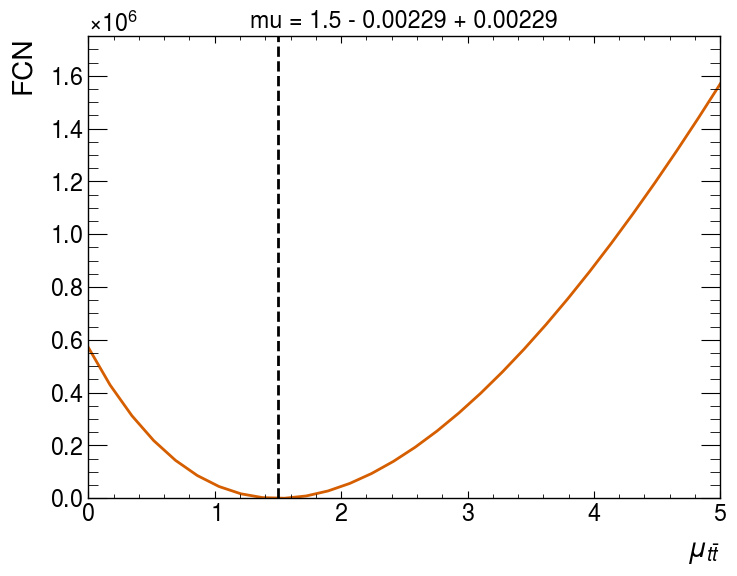

In [17]:
# Draw the profile likelihood scan for the POI mu, profiling the other 2 background nuisance parameters
m1.draw_mnprofile('mu', bound=(0.0, 5.0))
plt.axis(ymin=0.0)
plt.xlabel(r'$\mu_{t\bar{t}}$');

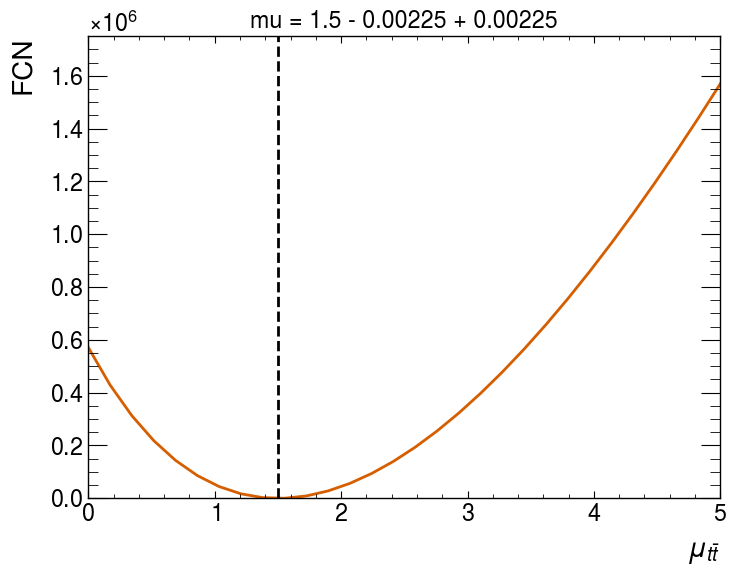

In [18]:
#m1.draw_mnprofile('mu', bound=(0.0, 5.0))
m1_flow.draw_mnprofile('mu', bound=(0.0, 5.0))
plt.axis(ymin=0.0)
plt.xlabel(r'$\mu_{t\bar{t}}$');

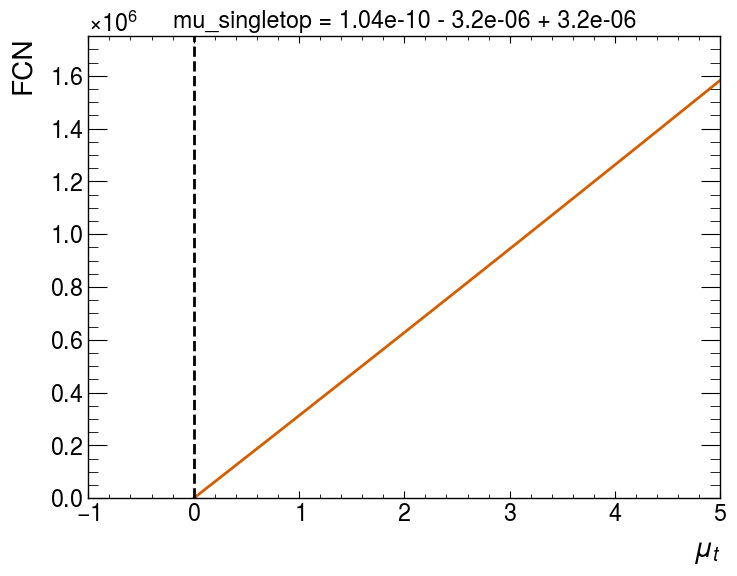

In [19]:
#m1.draw_mnprofile('mu_singletop', bound=(0.0, 5.0))
m1_flow.draw_mnprofile('mu_singletop', bound=(0.0, 5.0))
plt.axis(ymin=0.0)
plt.xlabel(r'$\mu_{t}$');

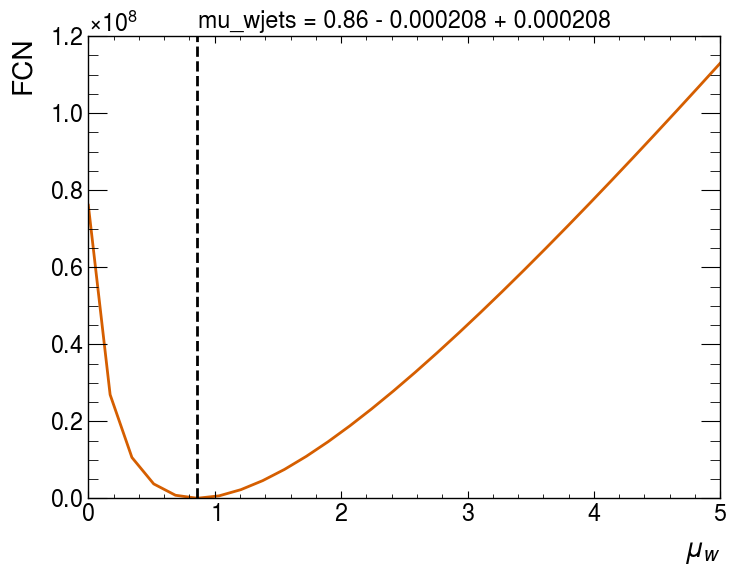

In [20]:
#m1.draw_mnprofile('mu_wjets', bound=(0.0, 5.0))
m1_flow.draw_mnprofile('mu_wjets', bound=(0.0, 5.0))
plt.axis(ymin=0.0)
plt.xlabel(r'$\mu_{w}$');

Note again that the best-fit values of even the background normalization parameters in this toy analysis with Asimov dataset does not converge to the truth value - $\widehat{\mu}_\text{bkg} \neq \mu^\text{truth}_\text{bkg} = 1.0$.